In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [62]:
# !unzip '/content/drive/MyDrive/archive.zip' -d '/content'

In [63]:
import os
from pathlib import Path
from google.colab.patches import cv2_imshow

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

### Loading the Data

In [86]:
BATCH_SIZE = 512
IMG_WIDTH = 200
IMG_HEIGHT = 50
MAX_LENGTH = 6

In [87]:
data_dir = Path('/content/images_before_edit/')

# downloading all images and converting them into list
images = sorted(list(map(str, list(data_dir.glob("*.png")))))

# getting all labels of images
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

# getting all characters from labels
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

In [88]:
print(len(images), len(labels))

64961 64961


### All characters for image names

In [89]:
# print all information about characters
digits = characters[:10]
letters = characters[10:]

print(f"Digits : {digits}")
print(f"Letters : {letters}")

Digits : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Letters : ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Coding and encoding functions

In [90]:
# converting a characters into number 
char_to_num = keras.layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)


# converting vice versa
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

### Spliting the Data
- Train Dataset : 80 %
- Validation Dataset : 10 %
- Test Dataset : 10 %

In [91]:
# data distribution
def split_data(images, labels, train_size=0.8, shuffle=True):
    size = len(images)

    # data shuffling
    np.random.seed(123)

    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)

    samples_80 = int(len(images) * train_size)
    samples_90 = int(len(images) * (train_size + (1 - train_size) / 2))

    x_train, y_train = images[indices[:samples_80]], labels[indices[:samples_80]]
    x_valid, y_valid = images[indices[samples_80:samples_90]], labels[indices[samples_80:samples_90]]
    x_test, y_test = images[indices[samples_90:]], labels[indices[samples_90:]]

    return x_train, x_valid, x_test, y_train, y_valid, y_test


x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(images), np.array(labels))

### Image processing and label encoding

In [92]:
# function for image processing and
# for label encoding to 'utf-8'
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)

    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.transpose(img, perm=[1, 0, 2])

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}

### Data manipulation with _.from_tensor_slices(...)_

In [93]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(8) # buffer_size=tf.data.AUTOTUNE
)


validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(8) # buffer_size=tf.data.AUTOTUNE
)


test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(8) # buffer_size=tf.data.AUTOTUNE
)

### Data visualization

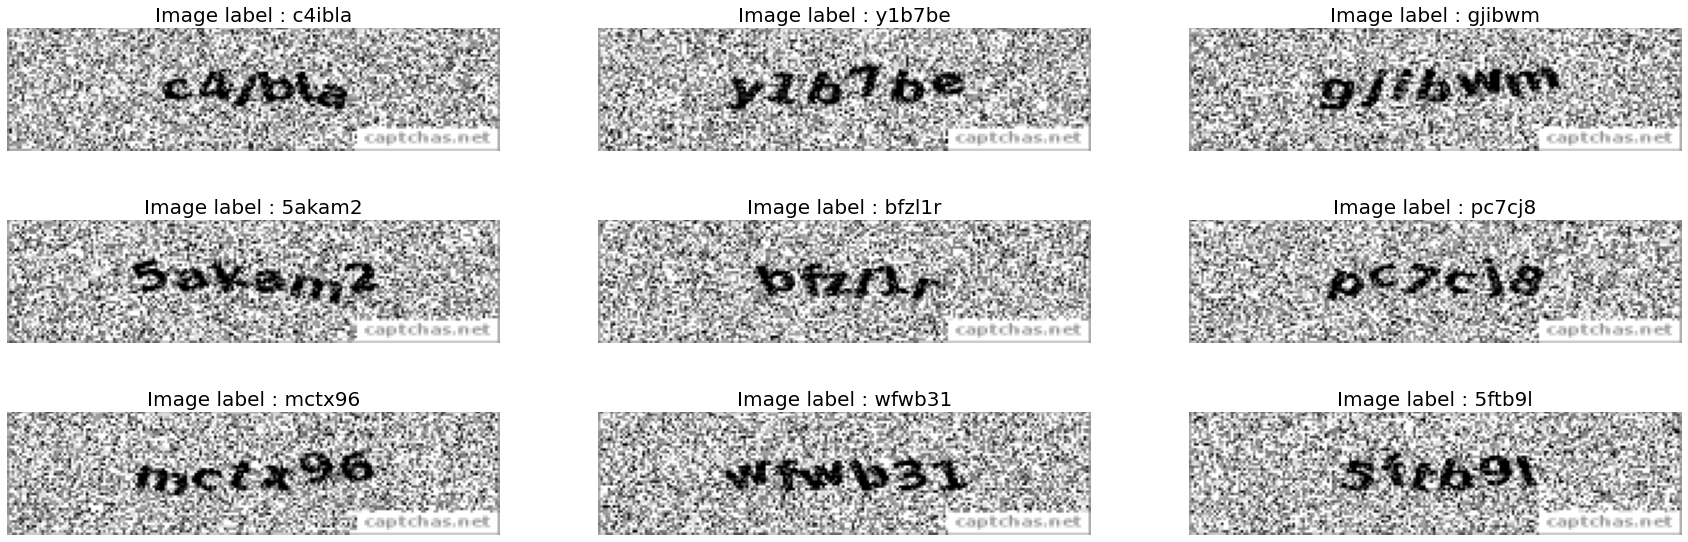

In [94]:
fig, ax = plt.subplots(3, 3, figsize=(30, 10))

for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(9):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        label_title = f"Image label : {label}"
        ax[i // 3, i % 3].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 3, i % 3].set_title(label_title, fontsize=20)
        ax[i // 3, i % 3].axis("off")

plt.show()

### OCR Model **CRNN** with **CTC-loss-function**

##### Defining the CTCLayer with ctc-loss-function :

In [95]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, **kwargs): # trainable=None
        super().__init__(**kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

##### Defining the structure of the model :

In [96]:
def build_model():
    input_img = keras.layers.Input(
        shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image", dtype="float32"
    )
    labels = keras.layers.Input(name="label", shape=(None,), dtype="float32")

    # 1 Conv2D()
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # 2 Conv2D()
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    new_shape = ((IMG_WIDTH // 4), (IMG_HEIGHT // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs
    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )

    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt)

    return model

In [97]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

### Saving and training the model 

In [98]:
EPOCHS = 100
FILEPATH = '/content/drive/MyDrive/project-captcha-recognition/TrainedModels/TrainedModel3.hdf5'

In [55]:
checkpoint = keras.callbacks.ModelCheckpoint(FILEPATH, save_best_only=True, save_weights_only=True, verbose=1)
history = model.fit(train_dataset ,validation_data=validation_dataset, epochs=EPOCHS, callbacks=[checkpoint])

##### Graph of loss drop while training 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(range(0, EPOCHS + 1, 10))
plt.title('CRNN Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

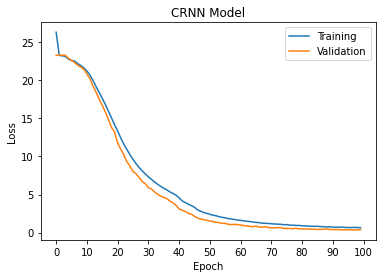

### Loading and checking the saved model

In [99]:
model.load_weights(FILEPATH)

In [100]:
loss = model.evaluate(test_dataset)

13/13 [==============================] - 39s 3s/step - loss: 0.1782


### Symbol decoding and predicting

In [102]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :MAX_LENGTH]
    output_text = []

    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
      
    return output_text

In [103]:
predicts = model.predict(test_dataset) # prediction of results
pred_texts = decode_batch_predictions(predicts)

### Visualization of our **correct predictions**

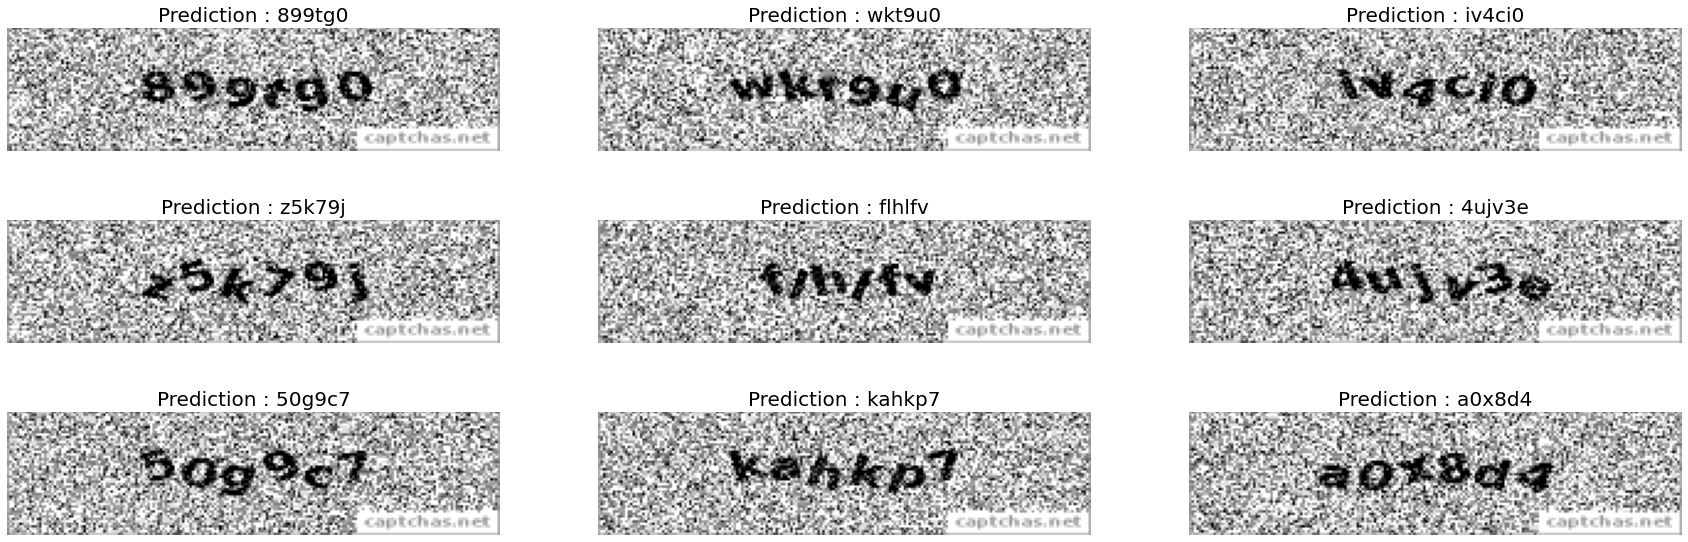

In [104]:
fig, ax = plt.subplots(3, 3, figsize=(30, 10))

for batch in test_dataset.take(1):
    batch_images = batch["image"]
    for i in range(9):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction : {pred_texts[i]}"
        ax[i // 3, i % 3].imshow(img, cmap="gray")
        ax[i // 3, i % 3].set_title(title, fontsize=20)
        ax[i // 3, i % 3].axis("off")

plt.show()

### Finding the correcting (edit) distance and highlighting the results

In [107]:
def edit_distance(string1, string2):
    len_st_1 = len(string1)
    len_st_2 = len(string2)

    if len_st_1 > len_st_2:
        difference = len_st_1 - len_st_2
        string1[:difference]
    elif len_st_2 > len_st_1:
        difference = len_st_2 - len_st_1
        string2[:difference] 
    else:
        difference = 0

    for i in range(len_st_1):
        if string1[i] != string2[i]:
            difference += 1

    return difference

In [124]:
wrong_preds = []
right_labels = []
edit_distances = []

for i in range(len(pred_texts)):
  distance = edit_distance(pred_texts[i], y_test[i])
  if distance >= 1:
    wrong_preds.append(pred_texts[i])
    right_labels.append(y_test[i])
  edit_distances.append(distance / 6)

wrong_labels_best = [wrong_preds[1], wrong_preds[2], wrong_preds[6], 
                     wrong_preds[7], wrong_preds[10], wrong_preds[11], 
                     wrong_preds[31], wrong_preds[38], wrong_preds[202]]

right_labels_best = [right_labels[1], right_labels[2], right_labels[6], 
                     right_labels[7], right_labels[10], right_labels[11], 
                     right_labels[31], right_labels[38], right_labels[202]]

print("Total number of mismatches : ", edit_distance(pred_texts, y_test))
print("Wrong prediction       : ", wrong_labels_best)
print("Right names of labels  : ", right_labels_best)
print("Mean of edit distances : ", round(np.mean(edit_distances), 3) * 100, "%")

Total number of mismatches :  203
Wrong prediction       :  ['lwk5tz', 'jkhnqe', 'xeymgn', 'aeagfp', 'lcmwkc', 'pl59g4', 'gbaesi', 'oylbzc', 'f1nl6o']
Right names of labels  :  ['iwk5tz', 'jkhnqa', 'xeymqn', 'aeagtp', 'icmwkc', 'pi59g4', 'gbasi8', 'eylbzc', 'f1ni6o']
Mean of edit distances :  0.8 %


### Visualization of our **incorrect predictions**

In [130]:
fig, ax = plt.subplots(3, 3, figsize = (30, 10))

for batch in test_dataset.take(1):
  batch_images = batch["image"]

  pred_texts_mistake = wrong_labels_best
  original_texts = right_labels_best

  for i in range(9):
      img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
      img = img.T
      title = f"Prediction : {pred_texts_mistake[i]} | Actual : {original_texts[i]}"
      ax[i // 3, i % 3].imshow(plt.imread(f'/content/images_before_edit/{original_texts[i]}.png'), cmap="gray")
      ax[i // 3, i % 3].set_title(title, fontsize=20) # fontdict={'fontsize': 20, 'fontweight': 'medium'}
      ax[i // 3, i % 3].axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### _Metrics_ for model

In [131]:
def check_similarity(string1, string2):
    for i in range(len(string1)):
      if string1[i] != string2[i]:
        return False
    return True


def get_distance(string1, string2):
    counter = 0

    if len(string1) != len(string2):
      return -1
    
    for i in range(len(string1)):
      if len(string1[i]) != len(string2[i]):
        counter += 1
      else:
        if not check_similarity(string1[i], string2[i]):
          counter += 1
    
    return counter

##### Calculating the accuracy :

In [132]:
def get_accuracy(predict, distance):
    if distance == -1:
      return distance
    return 1 - distance / len(predict)

In [133]:
print("Accuracy : ", get_accuracy(pred_texts, get_distance(pred_texts, y_test)))

Accuracy :  0.9687548099122671
